<a href="https://colab.research.google.com/github/Wkuzmicz00/genimal/blob/GENIMAL-2/SimpleAnimalRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [45]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [46]:
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.constant([[5.0, 6.0], [7.0, 8.0]])

# Perform calculation on GPU
with tf.device('/GPU:0'):
    c = tf.matmul(a, b)

print("Result: \n", c)

Result: 
 tf.Tensor(
[[19. 22.]
 [43. 50.]], shape=(2, 2), dtype=float32)


In [47]:
!nvidia-smi

Mon Nov 25 16:42:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0              29W /  70W |   3215MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("alessiocorrado99/animals10")

#print("Path to dataset files:", path)

100%|██████████| 586M/586M [00:26<00:00, 22.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [48]:
path_to_animals = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img"

In [49]:
# import shutil
path_to_smaller_animals = "/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/animals"
# os.makedirs(path_to_smaller_animals, exist_ok = True)
# for folder in os.listdir(path_to_animals):
#     dir_to_copy = f'{path_to_animals}/{folder}'
#     l = os.listdir(dir_to_copy)
#     print(folder)
#     os.makedirs(path_to_smaller_animals + '/' + folder, exist_ok = True)
#     for n in l[::10]:
#       target = dir_to_copy + '/' + n
#       print(target)
#       if os.path.isfile(target):
#           shutil.copy(target, os.path.join(path_to_smaller_animals, folder))

-rw-r--r-- 1 root root 9100 Nov 25 15:27 /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/animals/cane


In [50]:
batch_size = 8
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_smaller_animals,
    validation_split=0.2,
    seed=123,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2623 files belonging to 10 classes.
Using 2099 files for training.


In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_smaller_animals,
    validation_split=0.2,
    seed=123,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2623 files belonging to 10 classes.
Using 524 files for validation.


In [53]:
class_names = train_ds.class_names
print(class_names)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


0.0 1.0


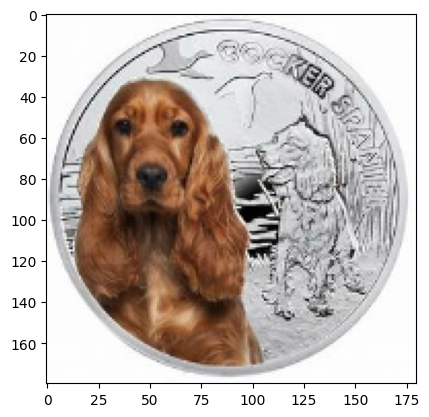

In [54]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
plt.imshow(first_image)
print(np.min(first_image), np.max(first_image))

In [55]:
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [57]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [58]:
model.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


263/263 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.1797 - loss: 2.2295 - val_accuracy: 0.2328 - val_loss: 2.1097
Epoch 2/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2887 - loss: 2.0200 - val_accuracy: 0.3531 - val_loss: 1.9805
Epoch 3/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3970 - loss: 1.7445 - val_accuracy: 0.3531 - val_loss: 1.9236
Epoch 4/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5148 - loss: 1.4216 - val_accuracy: 0.3187 - val_loss: 2.2631
Epoch 5/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6158 - loss: 1.0874 - val_accuracy: 0.3225 - val_loss: 2.3880
Epoch 6/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7302 - loss: 0.7924 - val_accuracy: 0.3206 - val_loss: 3.1836
Epoch 7/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8371 - loss: 0.5222 - val_accuracy: 0.3149 - val_loss: 4.0599
Epoch 8/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8883 - loss: 0.3768 - val_accuracy

In [68]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel"}
class_names = list(translate.values())

from tensorflow.keras.preprocessing import image
img = image.load_img("/content/images.jpg", target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
img_array = normalization_layer(img_array)
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=-1)[0]
predicted_class = class_names[predicted_class_index]
confidence = predictions[0][predicted_class_index]
print(f"Predicted class: {predicted_class}, Confidence: {confidence}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted class: dog, Confidence: 1.0
